Below are the instructions for the technical assessment. There are two parts: Data Science and Engineering. You should plan to spend about 1-2 hours on the Data Science portion and 1-2 hours on the engineering portion.

## Data Science

For the Data Science portion, it is important to note that your work won't be assessed on whether you get the best model, but that you understand important concepts behind analyzing the data, feature engineering and model development and evaluation. Keep this section simple, clear and illustrative of your understanding of how to prototype a model.

## Engineering

In a separate set of files (ie not in this Jupyter Notebook), take the model that you created and implement basic training and prediction pipelines that would simulate what you would implement in production. These pipelines should broadly cover the following steps:
* Preprocessing
  * This will be based off the raw data received at the beginning of DS assignment
* Model Training & Evaluation
* Predictions (in batch)

*Some Requirements*:
* The training and prediction pipelines should be independent of each other (though they can draw from the same base methods/classes if need be).
* The prediction job predicts on the latest "promoted" model.
* All model artifacts and outputs are stored according to date partition or, where relevant, by version
* The training job includes logic around "model promotion"
  * If there is an 10% increase in ROC/AUC over the previous model then promote model; else don't promote model
* For both jobs, a user (human or machine) should be able to simply call on the script or import a class to run the pipeline

*Bonus*:

Parameterize the pipelines according to how a Data Scientist would use this.
* Allow for arbitrary set of features to be passed into training (and prediction) job
* Parameterize the % threshold increase to promote a model
* Parameterize which evaluation metric can be used. To keep it simple, stick with most common metrics for evaluation


Organize the files in a folder structure that would emulate how you would organize the code in a Github repo. Zip up all files and send them back to the recruiter by the morning of your interview.

# Data Science Portion

## Imports

In [1]:
!pip install pandas 
!pip install numpy
!pip install -U scikit-learn
!pip install xgboost
!pip install matplotlib
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
import xgboost as xgb

import warnings
import math

from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.metrics import RocCurveDisplay


warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
# Add any other packages you would like to use here

## Dataset

The dataset in this notebook is representive of Vacasa's internal data.

In this notebook, we would like you to develop a model to predict whether a reservation will cancel and describe what the model learned. 

* The label in the dataset is given as `is_canceled`.
* For a complete description of dataset, visit the link: https://www.sciencedirect.com/science/article/pii/S2352340918315191

In [6]:
df = pd.read_csv('../data/train/hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Data Preparation

### Check/Replace missing values


Since we are lucky and have documentation of the data, we can do a little data cleaning. 
Some insightss from the document:

- **Agent/Company**: The PMS assured no missing data exists in its database tables. However, in some categorical variables like Agent or Company, "NULL" is presented as one of the categories. This should not be considered a missing value, but rather as "not applicable";
- **Country**: It is also common for hotels not to know the correct nationality of the customer until the moment of check-in;

In [7]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [8]:
df[df.children.isnull()]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
40600,City Hotel,1,2,2015,August,32,3,1,0,2,NaN,0,BB,PRT,Undefined,Undefined,0,0,0,B,B,0,No Deposit,NaN,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-01
40667,City Hotel,1,1,2015,August,32,5,0,2,2,NaN,0,BB,PRT,Direct,Undefined,0,0,0,B,B,0,No Deposit,14.0,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-04
40679,City Hotel,1,1,2015,August,32,5,0,2,3,NaN,0,BB,PRT,Undefined,Undefined,0,0,0,B,B,0,No Deposit,NaN,NaN,0,Transient-Party,18.0,0,2,Canceled,2015-08-04
41160,City Hotel,1,8,2015,August,33,13,2,5,2,NaN,0,BB,PRT,Online TA,Undefined,0,0,0,B,B,0,No Deposit,9.0,NaN,0,Transient-Party,76.5,0,1,Canceled,2015-08-09


In [10]:
replace_mapping = {
    'agent': 0,             # it is safe to replace with zero according to the documentation
    'company': 0,           # it is safe to replace with zero according to the documentation
    'country': 'Undefined', # hotels not to know the correct nationality of the customer until the moment of check-ingent
    'children': 0,          # only 4 records, 1 hotel, all canceled, reservation_status_date (2015-08-01 - 2015-08-09), 
                            # probably we can leave it with zeros, maybe some bug on website
}

df = df.fillna(replace_mapping)

### Convert data types

In [11]:
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['is_repeated_guest'] = pd.Categorical(df['is_repeated_guest'])

df['agent'] = pd.Categorical(df['agent'])
df['company'] = pd.Categorical(df['company'])

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September' , 'October', 'November', 'December']
df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], ordered=True, categories=months)


for column in df.select_dtypes(include='object').columns:
    df[column] = pd.Categorical(df[column], ordered=True)

df.dtypes

hotel                                   category
is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                      category
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                    category
country                                 category
market_segment                          category
distribution_channel                    category
is_repeated_guest                       category
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                      category
assigned_room_type  

### Outliers

Let's quickly check all the numerical values ​​for outliers.

At first glance everything looks normal. We have several suspicious values for adr: [-6.38, 5400.0].

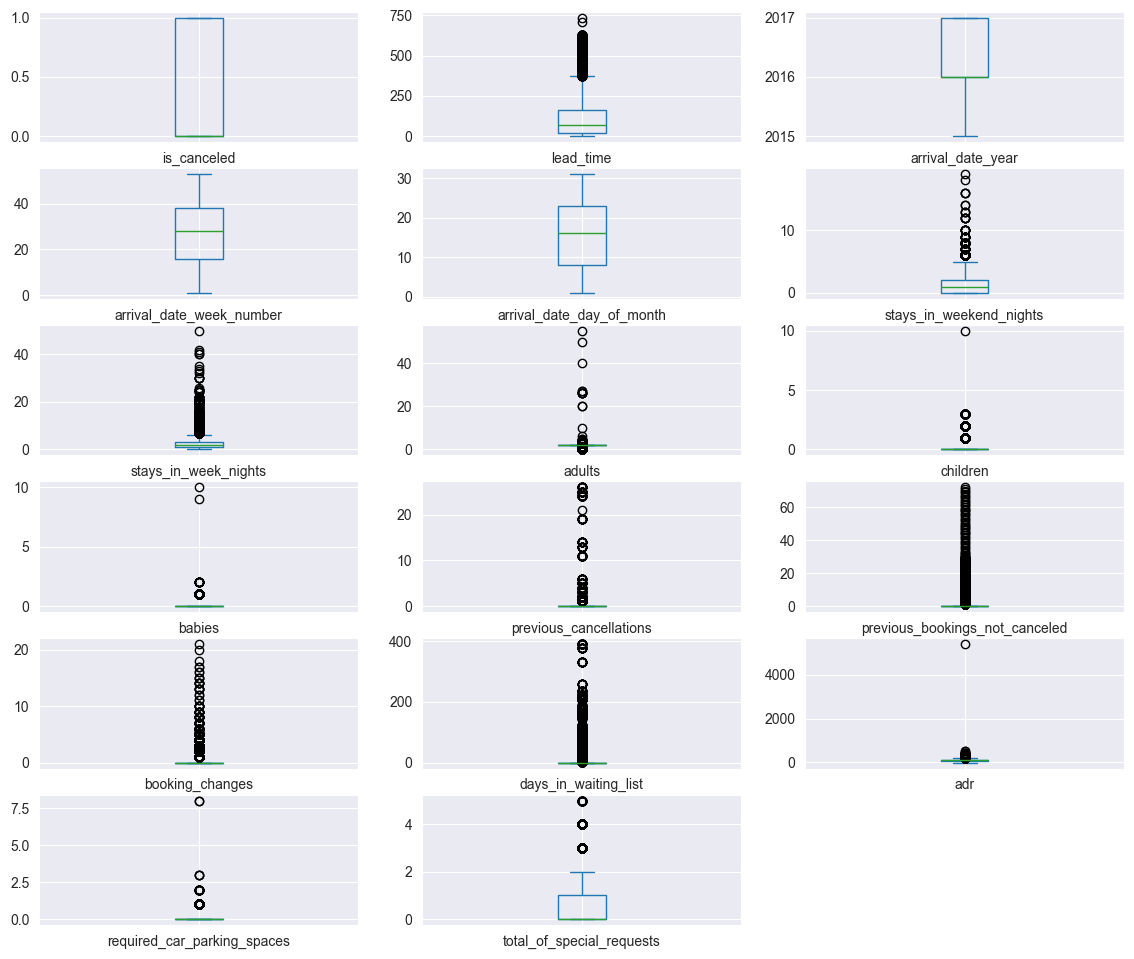

In [12]:
ncols = 3

df.select_dtypes(include='number').plot(
    kind='box', 
    subplots=True,
    sharey=False, 
    figsize=(14, 20), 
    layout=(len(df.columns) // ncols, ncols)
)
plt.show()

In [13]:
df = df[(df['adr'] < max(df['adr'])) & (df['adr'] >= 0)]

### Duplicates 31994 rows 

There are two possibilities here: 
1. The data was incorrectly queried from the server
2. The data is legitimate, this often happens in booking.

Ideally, you should ask the person who made the queries for the reason for the duplicates. 
Initially, I left the duplicates, but during the model's evaluation, 
I realized that these duplicates were leaking into the test dataset, leading to an inaccurate evaluation.luation.luation.ation..


In [14]:
df[df.duplicated()]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.00,0,1,Check-Out,2015-07-03
22,Resort Hotel,0,72,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,1,No Deposit,250.0,0.0,0,Transient,84.67,0,1,Check-Out,2015-07-07
43,Resort Hotel,0,70,2015,July,27,2,2,3,2,0.0,0,HB,ROU,Direct,Direct,0,0,0,E,E,0,No Deposit,250.0,0.0,0,Transient,137.00,0,1,Check-Out,2015-07-07
138,Resort Hotel,1,5,2015,July,28,5,1,0,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,240.0,0.0,0,Transient,97.00,0,0,Canceled,2015-07-01
200,Resort Hotel,0,0,2015,July,28,7,0,1,1,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,109.80,0,3,Check-Out,2015-07-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119349,City Hotel,0,186,2017,August,35,31,0,3,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0.0,0,Transient,126.00,0,2,Check-Out,2017-09-03
119352,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0.0,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
119353,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0.0,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
119354,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0.0,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03


In [15]:
df.drop_duplicates(inplace=True)

## Helpful EDA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87394 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           87394 non-null  category      
 1   is_canceled                     87394 non-null  int64         
 2   lead_time                       87394 non-null  int64         
 3   arrival_date_year               87394 non-null  int64         
 4   arrival_date_month              87394 non-null  category      
 5   arrival_date_week_number        87394 non-null  int64         
 6   arrival_date_day_of_month       87394 non-null  int64         
 7   stays_in_weekend_nights         87394 non-null  int64         
 8   stays_in_week_nights            87394 non-null  int64         
 9   adults                          87394 non-null  int64         
 10  children                        87394 non-null  float64       
 11  babies

### How balanced is the dataset?

hotel         is_canceled
City Hotel    0              37379
              1              16048
Resort Hotel  0              25991
              1               7976
Name: count, dtype: int64

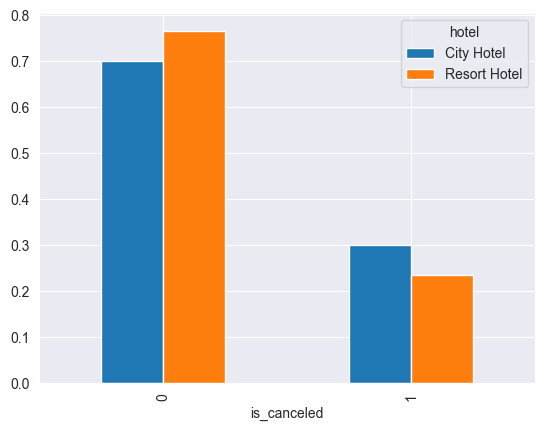

In [17]:
df_checked_out = df[df['is_canceled'] == 0].reset_index(drop=True)
df_canceled = df[df['is_canceled'] == 1].reset_index(drop=True)
df.groupby('hotel').is_canceled.value_counts(normalize=True).unstack(0).plot.bar()
df.groupby('hotel').is_canceled.value_counts()

### Guest Nationalities in Hotels

- most reservations are from Western Europe;
- most cancellations come from Portugal;
- City Hotel and Resort Hotel have different distributions between countries;


Text(0.5, 0.98, 'Guest Nationalities Ratio in Hotels')

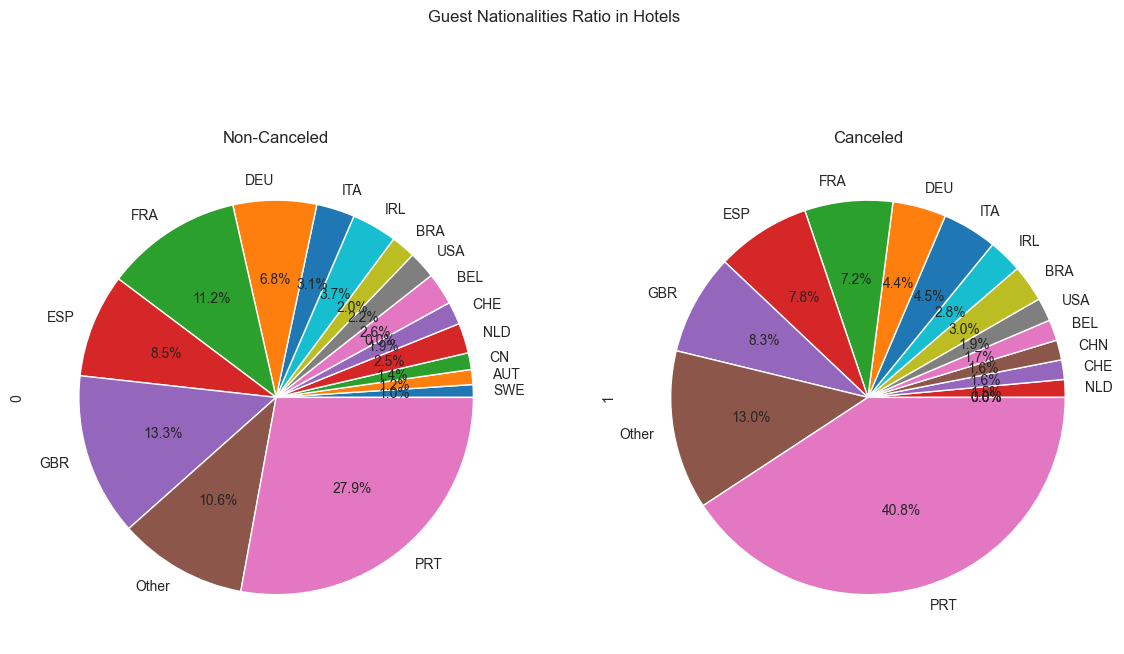

In [18]:
countries = df.groupby('is_canceled').country.value_counts(normalize=True).reset_index()
countries.country = countries.country.cat.add_categories(['Other'])
countries.loc[countries['proportion'] < 0.01, 'country'] = 'Other'
countries = countries.groupby(['is_canceled', 'country']).proportion.sum().sort_values()
countries[countries > 0].unstack(0).plot.pie(subplots=True, legend=False, autopct='%1.1f%%', figsize=(14, 8), title=['Non-Canceled', 'Canceled'])
plt.suptitle("Guest Nationalities Ratio in Hotels")

<Axes: title={'center': 'Per Hotel (Non-canceled)'}, xlabel='country'>

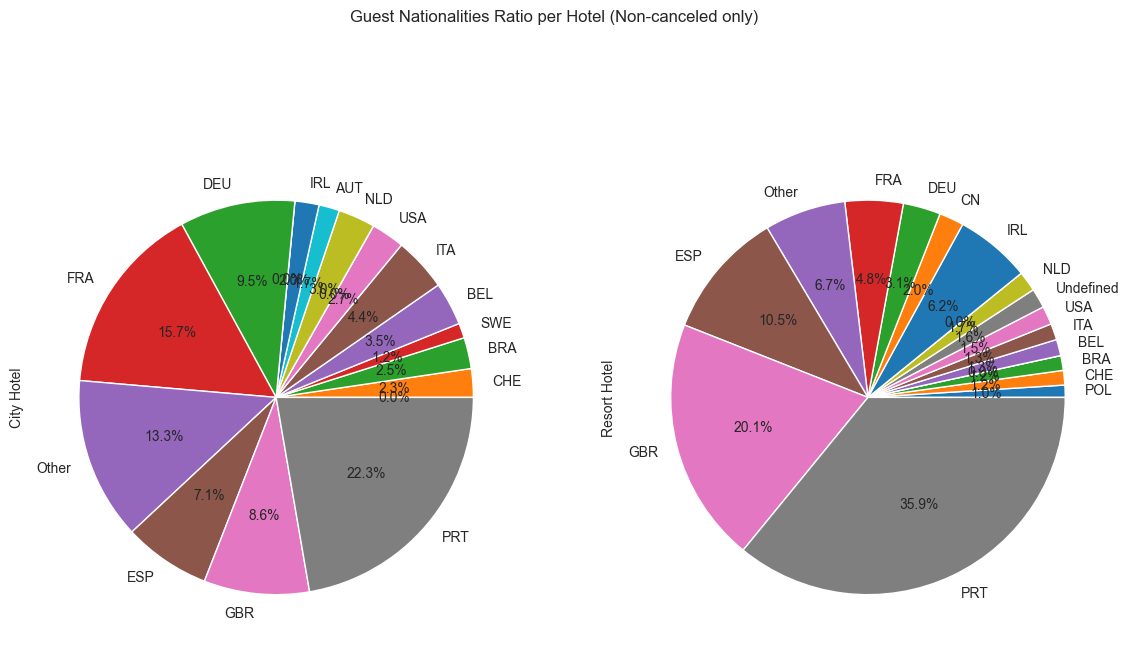

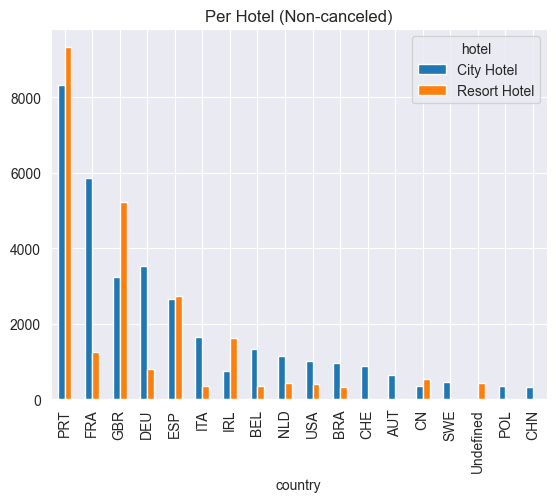

In [19]:
countries = df_checked_out.groupby('hotel').country.value_counts(normalize=True).reset_index()
countries.country = countries.country.cat.add_categories(['Other'])
countries.loc[countries['proportion'] < 0.01, 'country'] = 'Other'
countries = countries.groupby(['hotel', 'country']).proportion.sum().sort_values()
countries[countries > 0].unstack(0).plot.pie(subplots=True, legend=False, autopct='%1.1f%%', figsize=(14, 8))
plt.suptitle("Guest Nationalities Ratio per Hotel (Non-canceled only)")

df_checked_out.groupby('hotel').country.value_counts().nlargest(30).unstack(0).plot.bar(title="Per Hotel (Non-canceled)")

### ADR

- ADR distribution at a Сity Hotel is more uniform;
- In the case of a Resort Hotel, the ADR is significantly higher in the summer, which makes sense since demand increases in the summer and the price rises;

<Axes: title={'center': 'Mean ADR by Arival Month'}, xlabel='arrival_date_month'>

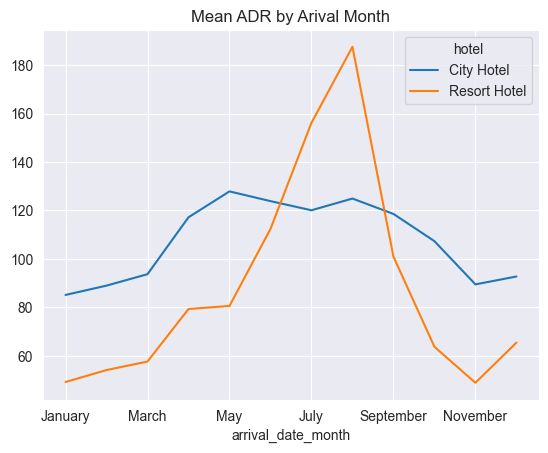

In [20]:
df.groupby(['hotel', 'arrival_date_month']).adr.mean().unstack(0).plot.line(title="Mean ADR by Arival Month")

### Reservations

- The number of reservations in summer is lower
- They differ between hotels, the reasons may be different, some guesses:
    - people stay for more days in the summer

<Axes: title={'center': 'Reservations per month (non-canceled)'}, xlabel='arrival_date_month'>

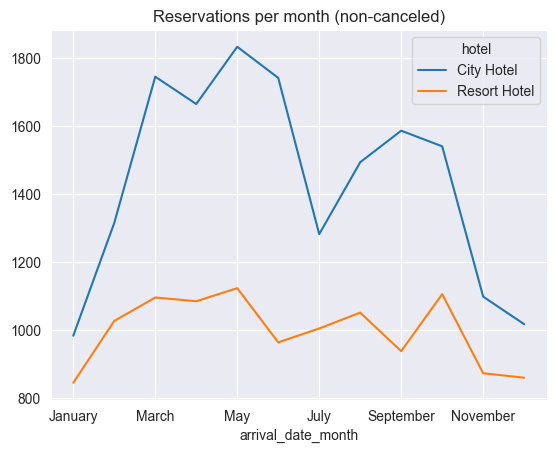

In [21]:
reservations = df_checked_out.groupby(['hotel', 'arrival_date_year', 'arrival_date_month']).hotel.count().reset_index(name='count')
reservations[reservations['count'] != 0].groupby(['hotel', 'arrival_date_month'])['count'].mean().unstack(0).plot.line(title='Reservations per month (non-canceled)')

### Cancelations

- There are more cancellations in summer for Resort Hotel
- No effect for City Hotel

<Axes: title={'center': 'Cancelations per month'}, xlabel='arrival_date_month'>

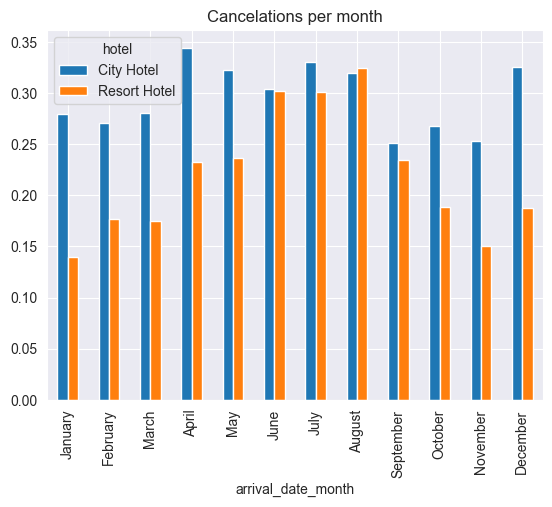

In [22]:
cancelations = df.groupby(['hotel', 'arrival_date_month']).agg(count=('is_canceled', 'count'), sum=('is_canceled', 'sum'))
cancelations['percentage'] = cancelations['sum'] / cancelations['count']
cancelations.percentage.unstack(0).plot.bar(title='Cancelations per month')

### How long does the client stay at the hotel?

- In summer people stay longer at the Resort Hotel

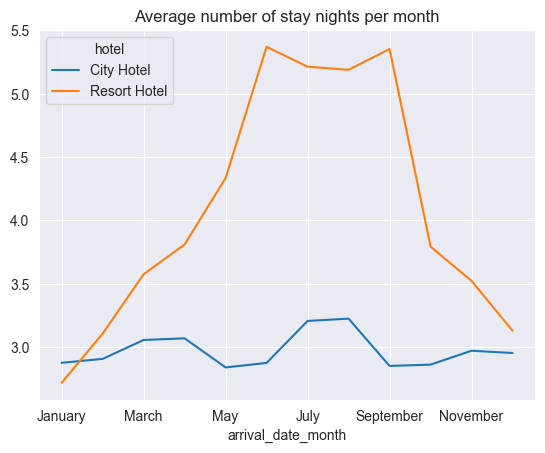

In [23]:
df_checked_out['stay_nights'] = df_checked_out['stays_in_weekend_nights'] + df_checked_out['stays_in_week_nights']

reservations = df_checked_out.groupby(['hotel', 'arrival_date_month']).stay_nights.mean().unstack(0).plot.line(title="Average number of stay nights per month")

### Stay Night

- Guests at the Resort Hotel tend to prefer staying for seven nights much more often.
- Should we include the day of the week as a feature?

<Axes: title={'center': 'Stay Nights (Non-canceled)'}, xlabel='stay_nights'>

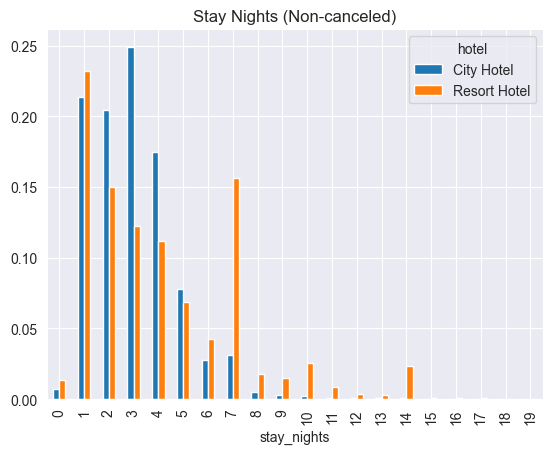

In [24]:
df_checked_out.groupby('hotel').stay_nights.value_counts(normalize=True).sort_index().unstack(0).head(20).plot.bar(title="Stay Nights (Non-canceled)")

### Deposit Type

- Why are non-refundable reservations canceled more often?

is_canceled,0,1
deposit_type,,
No Deposit,0.997854,0.958042
Non Refund,0.000868,0.040876
Refundable,0.001278,0.001082


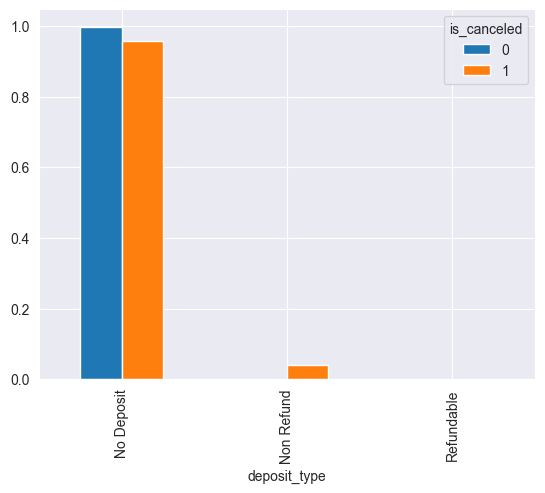

In [25]:
df.groupby('is_canceled').deposit_type.value_counts(normalize=True).unstack(0).plot.bar()
df.groupby('is_canceled').deposit_type.value_counts(normalize=True).unstack(0)

### Previous Cancelations
- If a guest has previously cancelled, there is a higher likelihood that they will cancel again.

<Axes: xlabel='previous_cancellations'>

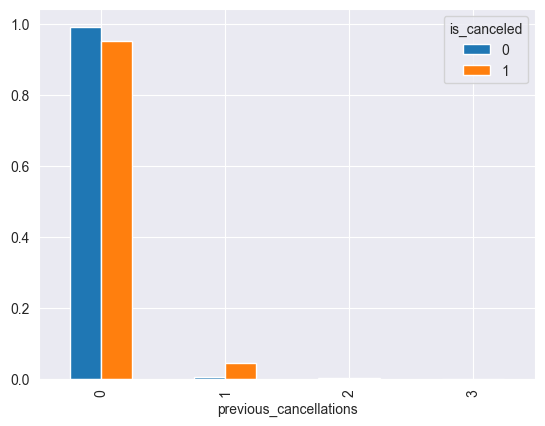

In [26]:
df.groupby('is_canceled').previous_cancellations.value_counts(normalize=True).unstack(0).head(4).plot.bar()

### Parking Spaces

- people who cancel their reservations never request a parking space (How this is possible, Issue in data?)
- perhaps this feature should be converted to binary

is_canceled,0,1
required_car_parking_spaces,,
0,0.884598,1.0
1,0.114881,NaN
2,0.000442,NaN
3,0.000047,NaN
8,0.000032,NaN


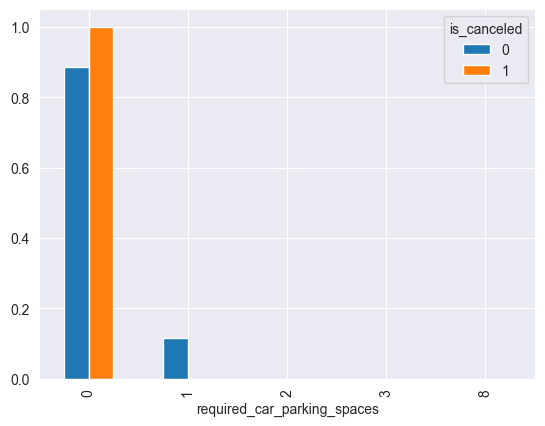

In [27]:
df.groupby('is_canceled').required_car_parking_spaces.value_counts(normalize=True).unstack(0).plot.bar()
df.groupby('is_canceled').required_car_parking_spaces.value_counts(normalize=True).unstack(0)

### Booking Changes

- looks like people who request changes to their bookings appear to cancel less frequently

is_canceled,0,1
booking_changes,,
0,0.787849,0.897769
1,0.148193,0.062854
2,0.044232,0.029304
3,0.011741,0.005453
4,0.004624,0.002622


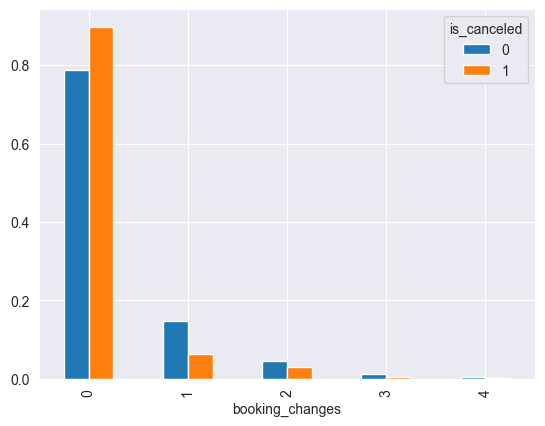

In [28]:
df.groupby('is_canceled').booking_changes.value_counts(normalize=True).unstack(0).head(5).plot.bar()
df.groupby('is_canceled').booking_changes.value_counts(normalize=True).unstack(0).head(5)

## Correlation
### Numerical features 

is_canceled  lead_time                         0.184830
             required_car_parking_spaces       0.184206
             adr                               0.133456
             total_of_special_requests         0.120538
             booking_changes                   0.093651
             arrival_date_year                 0.088046
             stays_in_week_nights              0.082957
             adults                            0.081815
             children                          0.067374
             stays_in_weekend_nights           0.060234
             previous_bookings_not_canceled    0.052146
             previous_cancellations            0.051469
             babies                            0.020542
             arrival_date_day_of_month         0.005300
             days_in_waiting_list              0.004465
             arrival_date_week_number          0.001453
dtype: float64

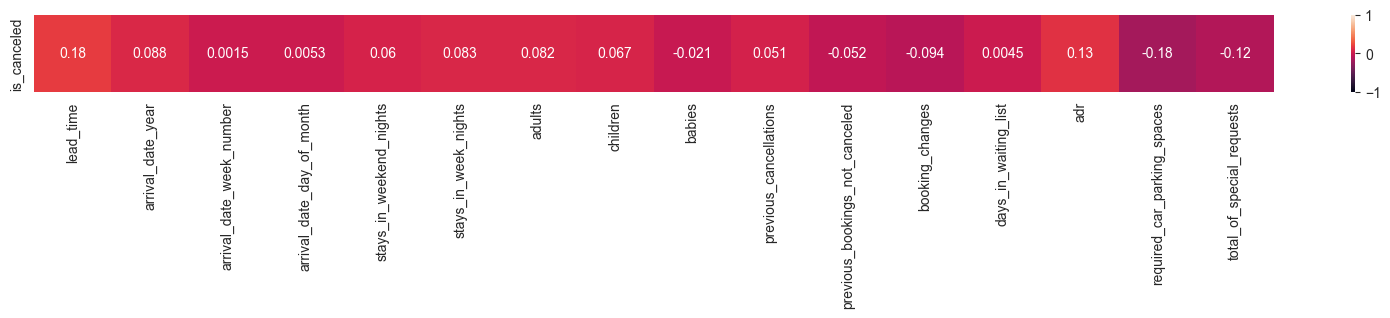

In [29]:
plt.figure(figsize=(20,1))
continuous_corr = df.select_dtypes(include='number').corr().drop(['is_canceled'], axis=1)
sns.heatmap(continuous_corr.loc[['is_canceled'],:], annot=True, vmin=-1, vmax=1) 
continuous_corr.loc[['is_canceled'],:].abs().stack().sort_values(ascending=False)

### Categorical features

is_canceled  reservation_status      1.000000
             agent                   0.080061
             market_segment          0.044444
             country                 0.033159
             distribution_channel    0.021890
             deposit_type            0.021114
             customer_type           0.015161
             company                 0.014540
             assigned_room_type      0.008609
             is_repeated_guest       0.008607
             arrival_date_month      0.006294
             hotel                   0.004413
             meal                    0.003304
             reserved_room_type      0.002798
dtype: float64

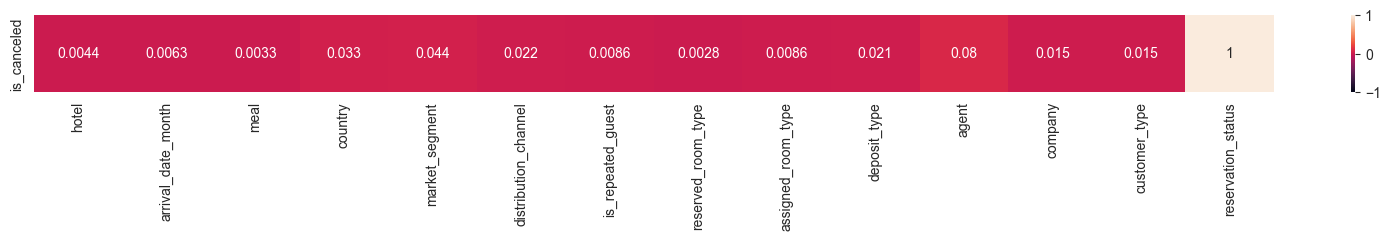

In [30]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


theilu = pd.DataFrame(index=['is_canceled'], columns=df.select_dtypes(include='category').columns)
columns = df.select_dtypes(include='category').columns

for j in range(0,len(columns)):
    u = theil_u(df['is_canceled'].tolist(),df[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u

theilu = theilu.astype(float)

plt.figure(figsize=(20,1))
sns.heatmap(theilu, annot=True, vmin=-1, vmax=1) 
theilu.stack().sort_values(ascending=False)

## Feature Engineering

- We need to drop the 'reservation_status' and 'reservation_status_date' features, as they are derived from future data.

In [31]:
data = df.drop(['reservation_status', 'reservation_status_date'], axis=1)

data['required_car_parking_spaces'] = np.where(data['required_car_parking_spaces'] > 0, 1, 0)
data['required_car_parking_spaces'] = pd.Categorical(data['required_car_parking_spaces'])

data['previous_cancellations'] = np.where(data['previous_cancellations'] > 0, 1, 0)
data['previous_cancellations'] = pd.Categorical(data['previous_cancellations'])


# date_data = data[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].astype(str)
# date_data.columns = ['year', 'month', 'day']
# data['weekday'] = pd.Categorical(pd.to_datetime(date_data.year + date_data.month + date_data.day, format='%Y%B%d').dt.dayofweek)

numerical_features = list(data.select_dtypes(include='number').columns)
categorical_features = list(data.select_dtypes(include='category').columns)

data.dtypes

hotel                             category
is_canceled                          int64
lead_time                            int64
arrival_date_year                    int64
arrival_date_month                category
arrival_date_week_number             int64
arrival_date_day_of_month            int64
stays_in_weekend_nights              int64
stays_in_week_nights                 int64
adults                               int64
children                           float64
babies                               int64
meal                              category
country                           category
market_segment                    category
distribution_channel              category
is_repeated_guest                 category
previous_cancellations            category
previous_bookings_not_canceled       int64
reserved_room_type                category
assigned_room_type                category
booking_changes                      int64
deposit_type                      category
agent      

## Model and Report

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     12696
           1       0.76      0.70      0.73      4782

    accuracy                           0.86     17478
   macro avg       0.82      0.81      0.81     17478
weighted avg       0.85      0.86      0.85     17478

Accuracy Score : 0.8565625357592402


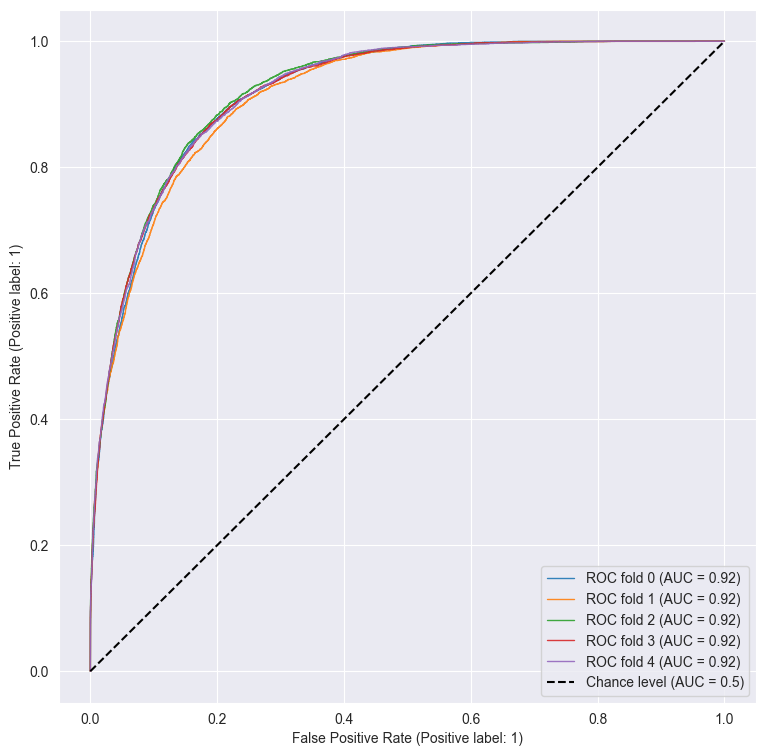

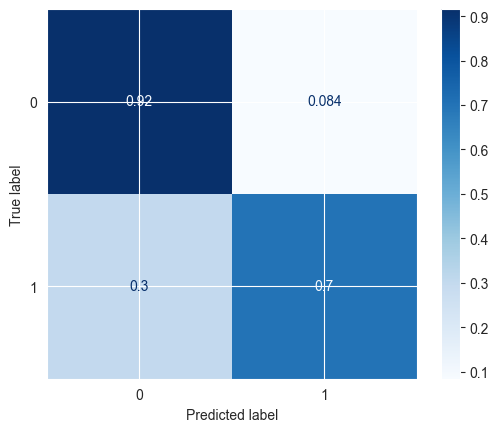

In [32]:
X = data.drop(["is_canceled"], axis=1)
y = data.is_canceled

#X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=0)
n_splits = 5
model = xgb.XGBClassifier(objective='binary:logistic', enable_categorical=True)
cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)

mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(9, 9))
for fold, (train, test) in enumerate(cv.split(X, y)):
    model.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.9,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )


ConfusionMatrixDisplay.from_estimator(
    model,
    X.iloc[test],
    y.iloc[test],
    display_labels=model.classes_,
    cmap=plt.cm.Blues,
    normalize='true',
)

y_pred = model.predict(X.iloc[test])
y_test = y.iloc[test]
print(classification_report(y_test, y_pred))
print(f"Accuracy Score : {accuracy_score(y_test, y_pred)}")

<Axes: >

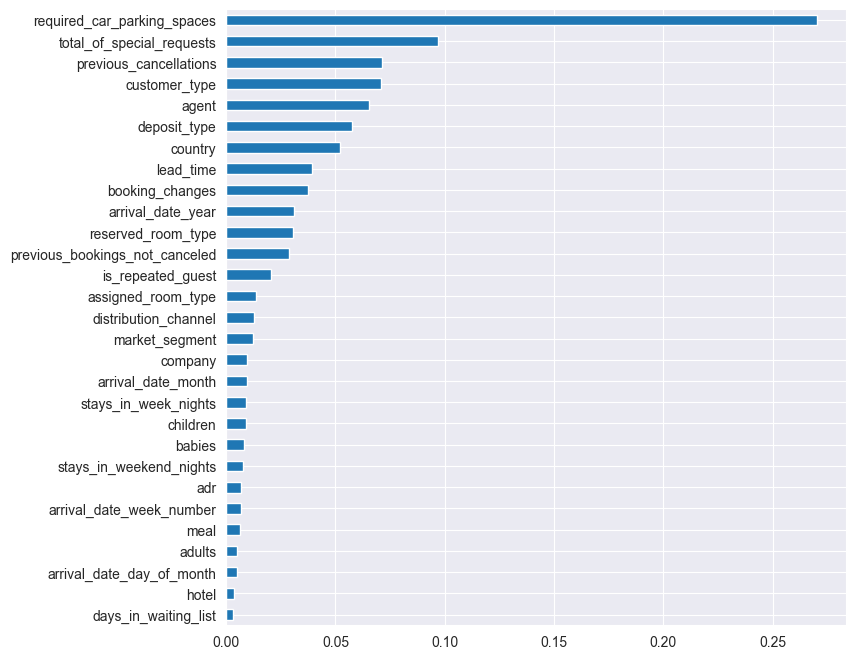

In [33]:
importances = model.feature_importances_
pd.Series(importances, index=X.columns).sort_values(ascending=True).plot.barh(figsize=(8, 8))